In [1]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_classic.tools import WikipediaQueryRun
from langchain_classic.utilities import WikipediaAPIWrapper
from langchain_classic.document_loaders import PyMuPDFLoader
from langchain_classic.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

from langgraph.graph import StateGraph, END, START

from langgraph_supervisor import create_supervisor
from langchain_classic.tools.retriever import create_retriever_tool
from langchain_groq import ChatGroq
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_classic.schema import Document
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
# Cell 6 (Update)
def make_retriever_from_pdf(file_path):
    all_docs = []
    
    for path in file_path:
        loader = PyMuPDFLoader(file_path=path)
        docs = loader.load()
        all_docs.extend(docs)
         
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=300)
    chunks = text_splitter.split_documents(all_docs)
    
    # Pastikan imports sudah ada (FAISS, OpenAIEmbeddings, dll)
    vectorstore = FAISS.from_documents(chunks, OpenAIEmbeddings())
        
    dense_retriever = vectorstore.as_retriever()
    sparse_retriever = BM25Retriever.from_documents(docs)
    sparse_retriever.k=3

    # Combine the retriever
    retriever = EnsembleRetriever(
        retrievers=[dense_retriever, sparse_retriever],
        weights=[0.5, 0.5]
    )
    
    print("Vectorstore & Retriever berhasil dibuat")
    return retriever  # <-- PENTING: Return Retriever-nya, bukan Tool

In [3]:
# Cell 37 (Update)
candidates = ["Andi.pdf", "budi.pdf", "siti.pdf"] # Pastikan path file benar

# 1. Buat Objek Retriever Murni (Dipakai oleh retrieve_agent)
candidate_retriever_obj = make_retriever_from_pdf(candidates)

# 2. Buat Tool dari Retriever tersebut (Dipakai oleh LLM/Router jika perlu)
candidate_retriever_tool = create_retriever_tool(
    candidate_retriever_obj,
    "CandidateRetriever",
    "Ini adalah informasi yang berisi pelamar pekerja..."
)

tavily_search = TavilySearch(max_results=2)

tools = [candidate_retriever_tool]

Vectorstore & Retriever berhasil dibuat


In [4]:

model = ChatGroq(model_name="openai/gpt-oss-120b",  streaming=True)
llm_with_tools = model.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000021855246060>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000218552E77A0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'), streaming=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'CandidateRetriever', 'description': 'Ini adalah informasi yang berisi pelamar pekerja...', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [5]:

class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]
    query_analisis : Literal["generate", "web_search", "retrieve"] = "generate"
    retrieved_doc : list[Document]
    grader_result : str = "yes"
    rewrite_query : str = "no"
    question : str =""
    active_query: str

    
    

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def contextualize_agent(state: State) -> State:
    print("--- CONTEXTUALIZE QUERY ---")
    
    messages = state["messages"]
    question = messages[-1].content
    
    if len(messages) <= 1:
        print("No history yet, skipping contextualization.")
        return {"messages": []}

    system_prompt = """Kamu adalah asisten AI yang bertugas memformulasi ulang pertanyaan user.
    Diberikan riwayat percakapan (chat history) dan pertanyaan terbaru pengguna yang mungkin merujuk pada konteks sebelumnya.
    
    Tugasmu:
    Formulasikan pertanyaan "standalone" (mandiri) yang dapat dipahami tanpa melihat riwayat obrolan.
    JANGAN menjawab pertanyaan tersebut. Cukup tulis ulang pertanyaannya agar jelas subjek/objeknya.
    
    Contoh:
    History: "Siapa itu Andi?" -> "Andi adalah programmer."
    User: "Berapa gajinya?"
    Output: "Berapa gaji Andi?"
    """
    
    contextualize_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="chat_history"),
            ("human", "{question}"),
        ]
    )
    

    history = messages[:-1]
    
    contextualizer = contextualize_prompt | model | StrOutputParser()
    
    refined_question = contextualizer.invoke({
        "chat_history": history,
        "question": question
    })
    
    print(f"Original: {question}")
    print(f"Contextualized: {refined_question}")
    
    return {
        "active_query": refined_question
    }

In [7]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["generate", "web_search", "retrieve"] = Field(
        ...,
        description="Pilih 'web_search' untuk berita/fakta terkini, 'retrieve' untuk data kandidat/CV/pelamar, atau 'generate' untuk chat umum/sapaan."
    )
    
def route_query_analisis(state: State) -> State:
    print("--- ROUTE QUERY ---")
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    question = state.get("active_query") or state["messages"][-1].content
    
    structured_llm_router = model.with_structured_output(RouteQuery)
    
    system_prompt = """Kamu adalah router cerdas. Tugasmu mengarahkan pertanyaan ke jalur yang tepat.
    1. 'retrieve': Jika user bertanya tentang KANDIDAT, PELAMAR, SKILL SESEORANG, atau CARI CV.
    2. 'web_search': Jika user tanya BERITA, FAKTA UMUM, atau DATA PASAR yang tidak ada di CV.
    3. 'generate': Jika user hanya menyapa (Halo, Pagi), berterima kasih, atau tanya hal umum (apa itu AI?).
    """
    
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{question}"),
        ]
    )

    router = route_prompt | structured_llm_router
    
    try:
        result = router.invoke({"question": question})
        decision = result.datasource
    except:
        # Fallback jika error parsing
        decision = "generate"

    print(f"Question: {question}")
    print(f"Decision: {decision}")
    
    return {
        "query_analisis": decision
    }
    

In [8]:
def web_search (state:State) -> State:
    query_analisis = state["query_analisis"][-1]
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    
    if human_messages:
        question = human_messages[-1].content
        print(f"Question: {question}")
    else:
        question = ""
        
        
    SYSTEM_PROMPT_WEB_SEARCH = """
        kamu adalah Agent yang berfokus pada web search.
        kamu akan menerima output dari agent sebelumnya yang menkategorikan pertanyaan terbaru seperti berita, kompleks dan sederhana.
        kamu menerima pertanyaan yang berhubungan dengan searching yaitu berita terbaru dll.
        jawablah pertanyaan user tersebut sesuai dengan conteks yang dia berikan.
    """
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_PROMPT_WEB_SEARCH),
            ("ai", "ini adalah hasil dari agent sebelumnya {query_analisis}"),
            ("user", "ini adalah peryanyaan user {question}")
        ]
    )
    
    chain_web_search = prompt | llm_with_tools
    result = chain_web_search.invoke(
        {
            "query_analisis": query_analisis,
            "question" : question
        }
    )
    
    return {
        "messages" : result,
    }
    

In [9]:
def route_query_analisis_to_generate(state: State) -> Literal["generate", "web_search", "retrieve"]:
 
    decision = state["query_analisis"] 
    
    print(f"--- ROUTING TO: {decision} ---")
    
    if decision == "web_search":
        return "web_search"
    elif decision == "retrieve":
        return "retrieve"
    else:
        return "generate"

In [10]:
web_search_agent = create_react_agent(
    name="SearchAgent",
    model = model,
    prompt = """kamu adalah Agent yang berfokus pada web search.
        kamu akan menerima output dari agent sebelumnya yang menkategorikan pertanyaan terbaru seperti berita, kompleks dan sederhana.
        kamu menerima pertanyaan yang berhubungan dengan searching yaitu berita terbaru dll.
        jawablah pertanyaan user tersebut sesuai dengan conteks yang dia berikan.""",
    tools= [tavily_search]
)

C:\Users\Farhan Kamil\AppData\Local\Temp\ipykernel_12780\1601538120.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_search_agent = create_react_agent(


In [11]:
def generate(state: State) -> State:
    print("--- GENERATE ---")
    
    # 1. Ambil Pertanyaan
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    question = human_messages[-1].content if human_messages else ""
    
    # 2. Ambil Dokumen dari State (PENTING!)
    # Dokumen tersimpan di sini, bukan di messages
    docs = state.get("retrieved_doc", []) 
    
    # Format dokumen menjadi string text agar bisa dibaca LLM
    context_text = ""
    if docs:
        # Menggabungkan isi semua halaman dokumen yang ditemukan
        context_text = "\n\n".join([d.page_content for d in docs])
    else:
        context_text = "Tidak ada dokumen yang ditemukan."

    # 3. Masukkan ke Prompt
    SYSTEM_PROMPT_GENERATE = """
    Kamu adalah asisten HR yang bertugas menjawab pertanyaan tentang kandidat pelamar kerja.
    JAWABLAH pertanyaan HANYA berdasarkan informasi yang ada di bagian KONTEKS di bawah ini.
    
    Jika informasi tidak ada di dalam konteks, katakan "Maaf, informasi tersebut tidak ditemukan dalam data kandidat."
    Jangan mengarang jawaban sendiri di luar konteks yang diberikan.
    """
    
    # Kita masukkan dokumen ke dalam prompt user atau system
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_PROMPT_GENERATE),
            ("user", "KONTEKS KANDIDAT:\n{context}\n\nPERTANYAAN USER:\n{question}")
        ]
    )
    
    chain_generate = prompt | model
    
    # 4. Invoke dengan Context
    response = chain_generate.invoke(
        {
            "context": context_text, # Kirim teks dokumen ke prompt
            "question": question
        }
    )
    
    return {
        "messages": [response]
    }

In [12]:
def retrieve_agent(state:State) -> State:
    question = state.get("active_query") or state["messages"][-1].content
    
    print(f"Retrieving for: {question}")
    
    docs = candidate_retriever_obj.invoke(question)
    
    return {
        "retrieved_doc": docs,
    }
        

In [13]:

class GradeDocuments(BaseModel):
    """Binary score untuk mengecek relevansi dokumen."""
    binary_score: str = Field(description="Dokumen relevan dengan pertanyaan user, 'yes' atau 'no'")

def grader_agent(state: State) -> State:
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    question = human_messages[-1].content if human_messages else ""
    
    retrieved_docs = state.get("retrieved_doc", [])
    
    # --- Setup LLM Grader ---
    llm = ChatOpenAI(model="gpt-5-nano-2025-08-07")
    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    system_prompt = """Kamu adalah seorang penilai (grader) yang mengevaluasi relevansi dokumen yang diambil terhadap pertanyaan pengguna.
    Jika dokumen berisi kata kunci atau makna semantik yang berkaitan dengan pertanyaan, nilailah sebagai relevan.
    Tujuanmu adalah memfilter dokumen yang salah atau tidak nyambung (hallucination).
    Berikan skor biner 'yes' atau 'no' untuk menunjukkan apakah dokumen tersebut relevan."""

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    grader_chain = grade_prompt | structured_llm_grader

    # --- Logika Filtering ---
    filtered_docs = []
    relevan = "No"

    print("--- CHECK DOCUMENT RELEVANCE ---")
    
    for doc in retrieved_docs:
        score = grader_chain.invoke({
            "question": question, 
            "document": doc.page_content
        })
        
        grade = score.binary_score
        
        if grade == "yes":
            print(f"--- GRADE: DOCUMENT RELEVANT ---")
            print(doc.page_content)
            filtered_docs.append(doc)
        else:
            print(f"--- GRADE: DOCUMENT NOT RELEVANT ---")
            print(doc.page_content)
            continue
            
    if not filtered_docs:
        print("--- NO RELEVANT DOCS FOUND, TRIGGER RE-WRITE QUERY ---")
        relevan = "yes"
    
    return {
        "retrieved_doc": filtered_docs,
        "rewrite_query" : relevan
        
    }

In [14]:
def rewrite_query(state: State) -> State:
    """
    Mengubah query user menjadi query yang lebih optimal untuk vector search.
    Dipanggil jika Grader merasa dokumen yang ditemukan sebelumnya tidak relevan.
    """
    print("--- TRANSFORM QUERY (REWRITE) ---")
    
    # 1. Ambil pertanyaan terakhir (bisa dari messages atau key 'question' di state)
    human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
    original_question = human_messages[-1].content if human_messages else ""
    
    # 2. Buat Prompt untuk Rewriting
    system_prompt = """Kamu adalah asisten AI yang ahli dalam mengoptimalkan query pencarian database.
    Tugasmu adalah melihat pertanyaan awal user, memahami inti masalahnya, 
    dan menulis ulang pertanyaan tersebut agar lebih jelas, spesifik, dan optimal untuk Vector Search.
    
    Hanya berikan output berupa query baru tanpa basa-basi/penjelasan lain."""
    
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Pertanyaan Awal: {question} \n\n Formulate an improved question:"),
        ]
    )

  
    question_rewriter = re_write_prompt | model | StrOutputParser()

    # 4. Eksekusi
    better_question = question_rewriter.invoke({"question": original_question})
    
    print(f"Original: {original_question}")
    print(f"Rewritten: {better_question}")

    return {
        "active_query": better_question
    }

In [15]:
from typing import Literal

def decide_to_generate(state) -> Literal["rewrite_query", "generate"]:
    """
    Menentukan apakah akan lanjut generate atau perlu search ulang
    berdasarkan hasil dari grader_agent.
    """
    
    # Ambil value yang tadi diset di grader_agent
    search_decision = state["rewrite_query"]
    
    print(f"--- DECISION: WEB SEARCH = {search_decision} ---")

    if search_decision == "Yes":
        # Jika dokumen tidak relevan, kita ke node perbaikan query/web search
        return "rewrite_query"
    else:
        # Jika dokumen relevan, kita langsung generate jawaban
        return "generate"

In [16]:
workflow = StateGraph(State)

workflow.add_node("contextualize", contextualize_agent)
workflow.add_node("web_search", web_search_agent)
workflow.add_node("generate", generate)
workflow.add_node("retrieve", retrieve_agent)
workflow.add_node("grader", grader_agent)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("query_analisis", route_query_analisis)


workflow.add_edge(START, "contextualize")
workflow.add_edge("contextualize", "query_analisis")
workflow.add_conditional_edges(
    "query_analisis",
    route_query_analisis_to_generate,
    {
        "generate" : "generate",
        "web_search" : "web_search",
        "retrieve" : "retrieve"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

workflow.add_edge("retrieve", "grader")
workflow.add_conditional_edges(
    "grader",
    decide_to_generate,
    {
        "rewrite_query" : "rewrite_query",
        "generate" :"generate"
    }
)
workflow.add_edge("rewrite_query", "retrieve")



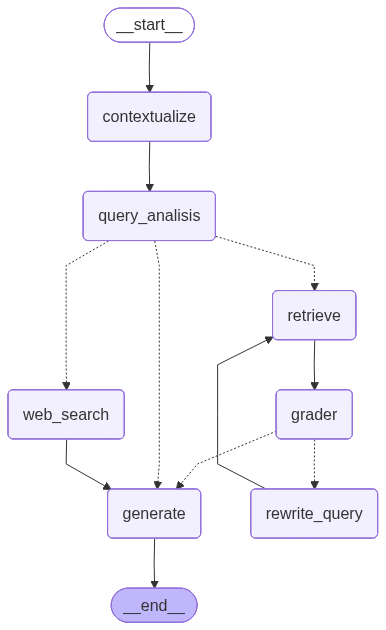

In [17]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [ ]:
config = {"configurable" : {"thread_id" : "6"}}

In [29]:
initial_input = {
    "messages": "carikan saya dua orang, pertama adalah front end engineer dan kedua yang mengerti tentang NLP dan AI engineer"
}

final_state = app.invoke(initial_input, config=config)

--- CONTEXTUALIZE QUERY ---
Original: carikan saya dua orang, pertama adalah front end engineer dan kedua yang mengerti tentang NLP dan AI engineer
Contextualized: Carikan dua kandidat: satu front‑end engineer dan satu lagi yang menguasai NLP serta AI.
--- ROUTE QUERY ---
Question: Carikan dua kandidat: satu front‑end engineer dan satu lagi yang menguasai NLP serta AI.
Decision: retrieve
--- ROUTING TO: retrieve ---
Retrieving for: Carikan dua kandidat: satu front‑end engineer dan satu lagi yang menguasai NLP serta AI.
--- CHECK DOCUMENT RELEVANCE ---
--- GRADE: DOCUMENT RELEVANT ---
Nama: Andi Pratama  
Email: andi.pratama@email.dummy  
Lokasi: Jakarta Selatan, Indonesia  
LinkedIn: linkedin.com/in/andipratama-ai 
Ringkasan Profesional AI Engineer berpengalaman dengan spesialisasi dalam Natural 
Language Processing (NLP) dan Generative AI. Memiliki pengalaman 4 tahun dalam 
membangun sistem retrieval-augmented generation (RAG) berskala besar dan deploy model 
LLM ke produksi. 
Pengala

In [30]:
for msg in final_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

carikan saya kandidat yang ahli dalam front end lalu yang ahli python atau AI?
================================== Ai Message ==================================

Maaf, informasi tersebut tidak ditemukan dalam data kandidat.
================================ Human Message =================================

carikan saya dua orang, pertama adalah front end engineer dan kedua yang mengerti tentang NLP dan AI engineer
================================== Ai Message ==================================

Berikut dua kandidat yang cocok dengan permintaan Anda:

| No | Nama Kandidat | Posisi yang Sesuai | Ringkasan Kompetensi (sesuai konteks) |
|----|---------------|--------------------|----------------------------------------|
| 1 | **Siti Rahmawati** | Front‑End Engineer | - Frontend Developer dengan pengalaman 3 tahun membangun aplikasi web responsif dan aksesibel menggunakan ekosistem React.<br>- Menguasai JavaScrip

In [31]:
initial_input = {
    "messages": "apakah mereka bisa kerja sama?"
}

final_state = app.invoke(initial_input, config=config)

--- CONTEXTUALIZE QUERY ---
Original: apakah mereka bisa kerja sama?
Contextualized: Apakah Siti Rahmawati dan Andi Pratama dapat bekerja sama?
--- ROUTE QUERY ---
Question: Apakah Siti Rahmawati dan Andi Pratama dapat bekerja sama?
Decision: retrieve
--- ROUTING TO: retrieve ---
Retrieving for: Apakah Siti Rahmawati dan Andi Pratama dapat bekerja sama?
--- CHECK DOCUMENT RELEVANCE ---
--- GRADE: DOCUMENT RELEVANT ---
Nama: Siti Rahmawati Email: siti.rahma@email.dummy Lokasi: Bandung, Jawa Barat 
Portfolio: sitirahma.dev 
Ringkasan Profesional Frontend Developer yang kreatif dengan mata yang tajam untuk 
desain UI/UX. Berpengalaman 3 tahun dalam membangun aplikasi web yang responsif dan 
aksesibel menggunakan ekosistem React. 
Pengalaman Kerja 
• 
Frontend Developer - KreatifDigital Studio (Feb 2022 - Sekarang) 
o Mengembangkan dashboard analitik interaktif menggunakan React.js, 
TypeScript, dan D3.js. 
o Berkolaborasi dengan tim desain untuk menerjemahkan mockup Figma 
menjadi kode pi

In [32]:
for msg in final_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

carikan saya kandidat yang ahli dalam front end lalu yang ahli python atau AI?
================================== Ai Message ==================================

Maaf, informasi tersebut tidak ditemukan dalam data kandidat.
================================ Human Message =================================

carikan saya dua orang, pertama adalah front end engineer dan kedua yang mengerti tentang NLP dan AI engineer
================================== Ai Message ==================================

Berikut dua kandidat yang cocok dengan permintaan Anda:

| No | Nama Kandidat | Posisi yang Sesuai | Ringkasan Kompetensi (sesuai konteks) |
|----|---------------|--------------------|----------------------------------------|
| 1 | **Siti Rahmawati** | Front‑End Engineer | - Frontend Developer dengan pengalaman 3 tahun membangun aplikasi web responsif dan aksesibel menggunakan ekosistem React.<br>- Menguasai JavaScrip

In [33]:
initial_input = {
    "messages": "Halo selamat pagi"
}

final_state = app.invoke(initial_input, config=config)

--- CONTEXTUALIZE QUERY ---
Original: Halo selamat pagi
Contextualized: Apa yang dapat saya bantu pada pagi ini?
--- ROUTE QUERY ---
Question: Apa yang dapat saya bantu pada pagi ini?
Decision: generate
--- ROUTING TO: generate ---
--- GENERATE ---


In [34]:
for msg in final_state["messages"]:
    msg.pretty_print()

================================ Human Message =================================

carikan saya kandidat yang ahli dalam front end lalu yang ahli python atau AI?
================================== Ai Message ==================================

Maaf, informasi tersebut tidak ditemukan dalam data kandidat.
================================ Human Message =================================

carikan saya dua orang, pertama adalah front end engineer dan kedua yang mengerti tentang NLP dan AI engineer
================================== Ai Message ==================================

Berikut dua kandidat yang cocok dengan permintaan Anda:

| No | Nama Kandidat | Posisi yang Sesuai | Ringkasan Kompetensi (sesuai konteks) |
|----|---------------|--------------------|----------------------------------------|
| 1 | **Siti Rahmawati** | Front‑End Engineer | - Frontend Developer dengan pengalaman 3 tahun membangun aplikasi web responsif dan aksesibel menggunakan ekosistem React.<br>- Menguasai JavaScrip